<div style="background: linear-gradient(135deg,rgb(65, 202, 179),rgb(201, 224, 96)); 
        color:rgb(0, 0, 0); 
        width: 100%; 
        height: 60px; 
        text-align: center; 
        font-weight: bold; 
        line-height: 60px; 
        margin: 2 px 0; 
        font-size: 44px; 
        border-radius: 10px; 
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.3);">
    Data Loading
</div>

In [1]:
%pip install language-tool-python python-Levenshtein wordcloud pyspellchecker torch transformers nltk
%pip install git+https://github.com/boudinfl/pke.git
%pip install git+https://github.com/PrithivirajDamodaran/Gramformer.git

!apt-get update
!apt-get install openjdk-17-jdk -y
!update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java
!update-alternatives --set javac /usr/lib/jvm/java-17-openjdk-amd64/bin/javac

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 73.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
####################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import language_tool_python     

import re
import nltk
import Levenshtein
import pkg_resources
from spellchecker import SpellChecker
from gramformer import Gramformer
from difflib import SequenceMatcher
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter, defaultdict
from string import punctuation
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.auto import tqdm

import logging
logging.getLogger().setLevel(logging.ERROR)  # Suppress Gramformer info messages

import warnings
warnings.filterwarnings('ignore')

E0000 00:00:1747584110.127143      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747584110.251253      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
file_path = '/kaggle/input/c4200m/C4_200M.tsv-00000-of-00010'
if os.path.exists(file_path):
    df = pd.read_csv(file_path, delimiter='\t')
    df.columns = ["text", "clean"]
    display(df.head(10))
    df2 = df.sample(n=5, random_state=42)
    dataset_sentences = df2['text'].tolist()
else:
    display(f"Error: File not found: {file_path}")

,text,clean
0,The effect of widespread dud targets two face ...,"1. The effect of ""widespread dud"" targets two ..."
1,tax on sales of stores for non residents are s...,Capital Gains tax on the sale of properties fo...
2,Much many brands and sellers still in the market.,Many brands and sellers still in the market.
3,this is is the latest Maintenance release of S...,This is is the latest maintenance release of S...
4,"Fairy Or Not, I'm the Godmother: no just look,...","Fairy Or Not, I'm the Godmother: Not just a lo..."
5,Watcch as this Dodge Challenger Hellcat gets s...,Watch as this Dodge Challenger Hellcat gets sm...
6,"Momover, these devices have been proven to hel...","Moreover, these devices are proven to help con..."
7,Ever cloud has a silver lining and it’s just p...,Every cloud has a silver lining and it’s just ...
8,Worthless involved's supporting for the movement.,Get involved and help the movement!
9,Mark Mohler said in a post on Instagram that h...,"On Wednesday, diver Mark Mohler said in a post..."


In [5]:
df = df.sample(n=250000, random_state=42) 
df.head()

,text,clean
16524230,If you want to chat with me about the topic (o...,If you want to have a chat with me about the t...
14371244,For up to date conversions redeem XE Currency.,For up to date conversions check XE Currency.
16248610,Update to check script checkglvmlsrpvclient.ks...,Update to check script checkglvmlsrpvclient.ks...
8379571,Three were given to the Fitzwilliam Museum in ...,Three were given to the Fitzwilliam Museum in ...
14101599,Ability to travels to the following countries ...,Ability to travels to the following countries ...


<div style="background: linear-gradient(135deg,rgb(65, 202, 179),rgb(201, 224, 96)); 
        color:rgb(0, 0, 0); 
        width: 100%; 
        height: 60px; 
        text-align: center; 
        font-weight: bold; 
        line-height: 60px; 
        margin: 2 px 0; 
        font-size: 44px; 
        border-radius: 10px; 
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.3);">
    Preprocessing & EDA
</div>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 16524230 to 12680287
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    250000 non-null  object
 1   clean   249997 non-null  object
dtypes: object(2)
memory usage: 5.7+ MB


In [7]:
display(df.isnull().sum())
print("-"*50)

df = df.dropna()
display(df.isnull().sum())

text     0
clean    3
dtype: int64

--------------------------------------------------


text     0
clean    0
dtype: int64

In [8]:
df['text']  = df['text'].str.lower()
df['clean'] = df['clean'].str.lower()
df.head()

,text,clean
16524230,if you want to chat with me about the topic (o...,if you want to have a chat with me about the t...
14371244,for up to date conversions redeem xe currency.,for up to date conversions check xe currency.
16248610,update to check script checkglvmlsrpvclient.ks...,update to check script checkglvmlsrpvclient.ks...
8379571,three were given to the fitzwilliam museum in ...,three were given to the fitzwilliam museum in ...
14101599,ability to travels to the following countries ...,ability to travels to the following countries ...


<h3 align="center"><strong>text cleaning</strong></h3>

In [9]:
def remove_spaces(text):
    """Remove undesired spaces and specific punctuation marks"""
    text = re.sub(r" '(\w)", r"'\1", text)              # Fix space before contraction: ' s → 's (e.g., I 'm → I'm)
    text = re.sub(r" \,", ",", text)                    # Remove space before comma: Hello , world → Hello, world
    text = re.sub(r" \.+", ".", text)                   # Remove space before multiple dots: Hello . . . → Hello.
    text = re.sub(r" \!+", "!", text)                   # Remove space before multiple exclamations: Hello ! ! ! → Hello!
    text = re.sub(r" \?+", "?", text)                   # Remove space before multiple question marks: Hello ? ? ? → Hello?
    text = re.sub(" n't", "n't", text)                  # Fix space in negation: can n't → can't
    text = re.sub("[\;\_\^\`\/]", "", text)             # Remove specific punctuation: ; _ ^ ` / (e.g., Hello;world → Helloworld)
    return text

def decontract(text):
    """Expand contractions to their full form"""
    text = re.sub(r"\'m", " am", text)                  # Expand 'm: I'm → I am
    text = re.sub(r"\'s", " is", text)                  # Expand 's: He's → He is
    text = re.sub(r"\'re", " are", text)                # Expand 're: They're → They are
    text = re.sub(r"\'t", " not", text)                 # Expand 't: Don't → Do not
    text = re.sub(r"\'d", " would", text)               # Expand 'd: He'd → He would
    text = re.sub(r"\'ll", " will", text)               # Expand 'll: They'll → They will
    text = re.sub(r"won\'t", "will not", text)          # Expand won't: won't → will not
    text = re.sub(r"can\'t", "can not", text)           # Expand can't: can't → can not
    text = re.sub(r"\'ve", " have", text)               # Expand 've: I've → I have
    return text

def preprocess_text(col):
    """Preprocess a text column (works for both incorrect and correct sentences)"""
    df[col] = df[col].astype(str)
    df[col] = df[col].apply(lambda x: x.lower())                          # HELLO → hello
    df[col] = df[col].apply(lambda x: re.sub("\n", "", x))                # \n → " "
    df[col] = df[col].apply(lambda x: remove_spaces(x))                   # Hello , world → Hello, world
    df[col] = df[col].apply(lambda x: decontract(x))                      # can't → can not
    df[col] = df[col].apply(lambda x: re.sub(r"[^A-Za-z\s.,!?]", "", x))  # Hello123!@ → Hello! (also removes digits)
    df[col] = df[col].apply(lambda x: re.sub(r"\s+", " ", x))             # Hello  world → Hello world
    df[col] = df[col].apply(lambda x: x.strip())                          # " Hello " → "Hello"
    return df

In [10]:
# Apply Cleaning 
df = preprocess_text('text')
df = preprocess_text('clean')

# Calculating the length of sentences
df['input_len'] = [len(text.split()) for text in df['text']]
df['label_len'] = [len(text.split()) for text in df['clean']]

# Filtering sentences (selcet lens between [5:20])
df = df[~(df['input_len'] < 5) & ~(df['input_len'] > 20)]
df = df[~(df['label_len'] < 5) & ~(df['label_len'] > 20)]

df.head(10)

,text,clean,input_len,label_len
14371244,for up to date conversions redeem xe currency.,for up to date conversions check xe currency.,8,8
16248610,update to check script checkglvmlsrpvclient.ks...,update to check script checkglvmlsrpvclient.ks...,12,12
14101599,ability to travels to the following countries ...,ability to travels to the following countries ...,17,16
18029110,i highly encourage you to use these storier is...,i highly encourage you to use these stories as...,15,19
3030140,i listens you and others.,i listen to you and others.,5,6
4718230,welcomed to phoenicia business center!,welcome to phoenicia business center!,5,5
9225164,nah my hair make me cute my attitude make me a...,"nah my hair makes me cute, my attitude makes m...",12,12
6116555,ensure you read the terms and conditions of se...,ensure you read the terms and conditions of se...,20,20
18153701,you can imagine my devastation when it buned a...,you can imagine my devastation when it burned ...,9,9
8529178,view the i dont know youtube video based on an...,"view the i dont know youtube video, based on a...",15,15


<h3 align="center"><strong>Checking for Duplicates</strong></h3>

**Benefit**: Removing duplicate rows ensures that the model does not learn from the same example multiple times, which improves accuracy and reduces bias toward specific patterns. 

In [ ]:
print(f"Number of rows before removing duplicates: {len(df)}")
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Number of rows after  removing duplicates: {len(df)}")

Number of rows before removing duplicates: 138216
Number of duplicate rows: 3
Number of rows after  removing duplicates: 138213


<div style="background: linear-gradient(135deg,rgb(65, 202, 179),rgb(201, 224, 96)); 
        color:rgb(0, 0, 0); 
        width: 100%; 
        height: 60px; 
        text-align: center; 
        font-weight: bold; 
        line-height: 60px; 
        margin: 2 px 0; 
        font-size: 44px; 
        border-radius: 10px; 
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.3);">
    Some Visualizations
</div>

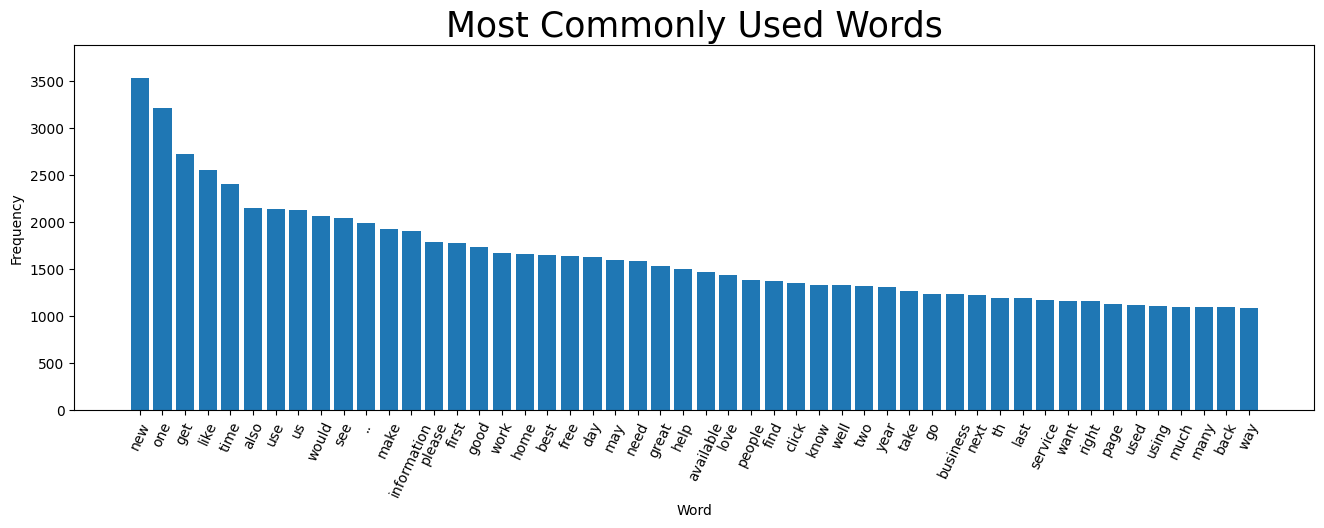

In [ ]:
def MostWordsUsed(n_words):
    # Join text with spaces
    all_text = ' '.join(df['clean'].astype(str).values)

    # Tokenize words
    words = nltk.word_tokenize(all_text)

    # Remove punctuation
    puncs = list(punctuation)
    words = [word for word in words if word not in puncs]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Count words
    word_count = Counter(words)
    top_words = word_count.most_common(n_words)

    return top_words

top_words = MostWordsUsed(50)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis, yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=65)
plt.ylim(0, max(yaxis) * 1.1)
plt.subplots_adjust(bottom=0.15)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

Counter({'misspelling': 149, 'typographical': 89, 'grammar': 8, 'whitespace': 5, 'Other': 3})
--------------------------------------------------


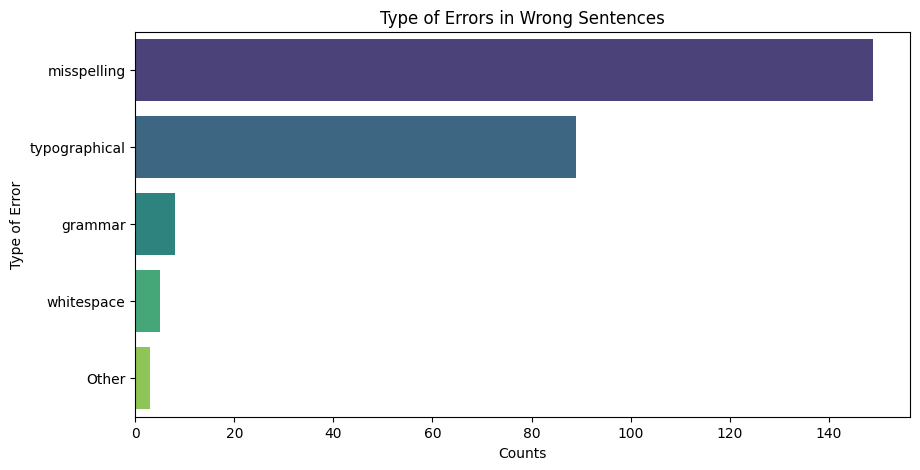

In [14]:
tool = language_tool_python.LanguageTool('en-US')

def analyze_errors(text):
    matches = tool.check(text)
    error_types = [match.ruleIssueType for match in matches]
    return error_types

# Sample 100 sentences and analyze errors
sample_df = df.sample(n=100, random_state=42)
tqdm.pandas()

sample_df['error_types'] = sample_df['text'].progress_apply(analyze_errors)
sample_df['error_types'] = sample_df['error_types'].apply(lambda x: x if isinstance(x, list) else [])

# Flatten and count errors
all_errors   = sum(sample_df['error_types'], [])
error_counts = Counter(all_errors)

# Group rare errors into "Other"
threshold       = 5
others_count    = sum(count for error, count in error_counts.items() if count < threshold)
filtered_errors = {error: count for error, count in error_counts.items() if count >= threshold}
if others_count > 0:
    filtered_errors['Other'] = others_count
error_counts = Counter(filtered_errors)

print(error_counts)
print("-"*50)
plt.figure(figsize=(10,5))
sorted_errors = dict(sorted(error_counts.items(), key=lambda x: x[1], reverse=True))
sns.barplot(x=list(sorted_errors.values()), y=list(sorted_errors.keys()), palette='viridis')
plt.title("Type of Errors in Wrong Sentences")
plt.xlabel("Counts")
plt.ylabel("Type of Error")
plt.show()

error_types,typographical,misspelling,whitespace,grammar,uncategorized
length_category,,,,,
middle,38,55,2,3,1
long,27,38,2,1,0
very long,22,52,1,4,2
short,2,4,0,0,0


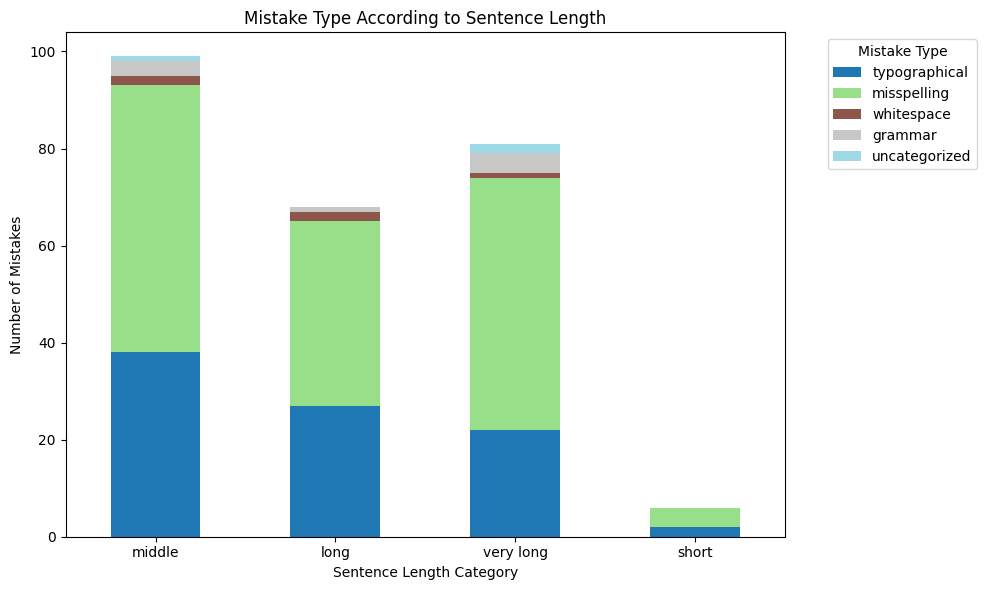

In [18]:
# Assuming sample_df is already created with num_errors and input_len
sample_df['length_category'] = pd.cut(sample_df['input_len'], bins=[0, 5, 10, 15, 25], labels=['short', 'middle', 'long', 'very long'])

# Ensure sample_df has the required columns
sample_df = sample_df.dropna(subset=['length_category', 'error_types'])

# Count error types by length category
error_type_by_length = defaultdict(Counter)
for _, row in sample_df.iterrows():
    length_cat = row['length_category']
    for error in row['error_types']:
        error_type_by_length[length_cat][error] += 1

error_df = pd.DataFrame(error_type_by_length).fillna(0).astype(int).T
error_df.index.name = "length_category"
error_df.columns.name = "error_types"
display(error_df)

error_df.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title("Mistake Type According to Sentence Length")
plt.ylabel("Number of Mistakes")
plt.xlabel("Sentence Length Category")
plt.xticks(rotation=0)
plt.legend(title='Mistake Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

,edit_type,count,percentage
0,Same length,2168,43.36
1,Deleting words,1547,30.94
2,Adding words,1285,25.70


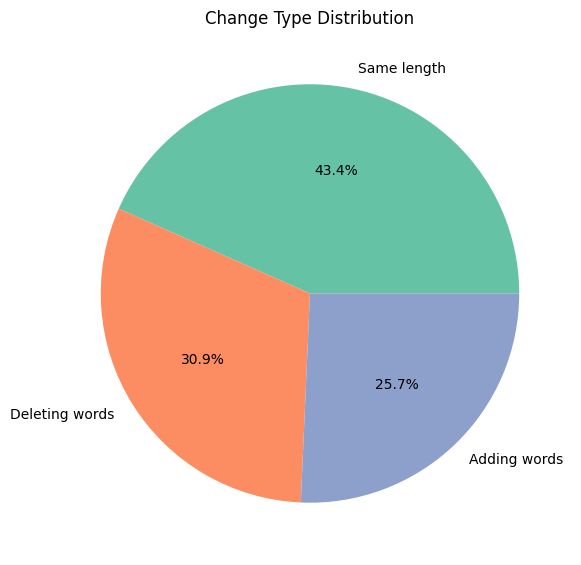

In [19]:
# Use a consistent sample
sample_df = df.sample(n=5000, random_state=42)
sample_df['input_len'] = sample_df['text'].apply(lambda x: len(str(x).split()))
sample_df['label_len'] = sample_df['clean'].apply(lambda x: len(str(x).split()))
sample_df['diff_len']  = sample_df['label_len'] - sample_df['input_len']

# Classify changes
def classify_change(diff):
    if diff > 0:
        return "Adding words"
    elif diff < 0:
        return "Deleting words"
    else:
        return "Same length"

sample_df['edit_type'] = sample_df['diff_len'].apply(classify_change)

# Calculate counts and percentages
edit_counts = sample_df['edit_type'].value_counts()
edit_counts_percent = sample_df['edit_type'].value_counts(normalize=True) * 100

# Create DataFrame with 3 columns
edit_df = pd.DataFrame({
    'edit_type': edit_counts.index,
    'count': edit_counts.values,
    'percentage': edit_counts_percent.values.round(2)})

# Display the DataFrame
display(edit_df)

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(edit_df['count'], labels=edit_df['edit_type'], autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title("Change Type Distribution")
plt.tight_layout()
plt.show()

* ### Let's clean after reviewing the visualizations

In [20]:
display(df.head())
df.drop(['input_len', 'label_len'], axis=1, inplace=True)
display(df.head())

,text,clean,input_len,label_len
14371244,for up to date conversions redeem xe currency.,for up to date conversions check xe currency.,8,8
16248610,update to check script checkglvmlsrpvclient.ks...,update to check script checkglvmlsrpvclient.ks...,12,12
14101599,ability to travels to the following countries ...,ability to travels to the following countries ...,17,16
18029110,i highly encourage you to use these storier is...,i highly encourage you to use these stories as...,15,19
3030140,i listens you and others.,i listen to you and others.,5,6


,text,clean
14371244,for up to date conversions redeem xe currency.,for up to date conversions check xe currency.
16248610,update to check script checkglvmlsrpvclient.ks...,update to check script checkglvmlsrpvclient.ks...
14101599,ability to travels to the following countries ...,ability to travels to the following countries ...
18029110,i highly encourage you to use these storier is...,i highly encourage you to use these stories as...
3030140,i listens you and others.,i listen to you and others.


In [21]:
def Vectorization(col, MAXLEN=20):
    sents = df[col].tolist()

    # Build vocabulary
    corpus = [word for text in df[col] for word in text.split()]
    vocab_size = len(Counter(corpus))

    tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>", filters='!#$%&()*+,-./:;<=>@«»""[\\]^_`{|}~\t\n\'')
    tokenizer.fit_on_texts(sents)

    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Text Vectorization
    seqs = tokenizer.texts_to_sequences(sents)
    pad_seqs = pad_sequences(seqs, maxlen=MAXLEN, padding='post')

    return pad_seqs, tokenizer

In [22]:
text_seqs, text_tokenizer   = Vectorization('text')
clean_seqs, clean_tokenizer = Vectorization('clean')

clean_sent = ' '.join([clean_tokenizer.index_word[idx] for idx in clean_seqs[15] if idx != 0])
print(f"{clean_seqs[15]} \n\n {clean_sent}")

[   1 2746 1542  648    4 2864  245    0    0    0    0    0    0    0
    0    0    0    0    0    0] 

 <OOV> convert html files to php program


In [23]:
print(f"The size of the source vocab size: {len(text_tokenizer.word_index)}")
print(f"The size of the target vocab size: {len(clean_tokenizer.word_index)}\n")

x_train, x_val, y_train, y_val = train_test_split(text_seqs, clean_seqs, train_size=0.80, random_state=42)

print(f"x_train shape: {x_train.shape}")
print(f"x_val   shape: {x_val.shape}")

The size of the source vocab size: 136672
The size of the target vocab size: 104865

x_train shape: (110570, 20)
x_val   shape: (27643, 20)


### **Why Vectorization is Essential** : to Convert text to numbers so ML models can process language.

### **Key Benefits**

| Aspect          | Impact                                                                 |
|-----------------|-----------------------------------------------------------------------|
| **Model Input** | Transforms raw text → numerical tensors models understand             |
| **Consistency** | Pads sequences to equal length for batch processing                   |
| **Performance** | Optimized for GPU acceleration in frameworks like TensorFlow/PyTorch  |

### **Grammar Correction Flow**
1. **Input**: Vectorized incorrect text (`text_seqs`)  
2. **Target**: Vectorized corrected text (`clean_seqs`)  
3. **Learning**: Model maps patterns between incorrect→correct sequences

### **Next Steps**
1. Build seq2seq model (LSTM/Transformer)  
2. Train using vectorized data  
3. Convert predictions back to text

> **< OOV > = Out Of Vocabulary**

<div style="background: linear-gradient(135deg,rgb(65, 202, 179),rgb(201, 224, 96)); 
        color:rgb(0, 0, 0); 
        width: 100%; 
        height: 60px; 
        text-align: center; 
        font-weight: bold; 
        line-height: 60px; 
        margin: 2 px 0; 
        font-size: 44px; 
        border-radius: 10px; 
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.3);">
    Spell & Grammer Correction
</div>

In [26]:
# Initialize Gramformer
try:
    USE_GPU = False
    gf = Gramformer(models=1, use_gpu=USE_GPU)
except Exception as e:
    logging.error(f"Failed to initialize Gramformer: {e}")
    gf = None

# Define 10 new sentences with errors
new_sentences = [
    "I doesnt no how to spel corectly.",
    "She buyed a new car yesturday.",
    "They was runing in the parck.",
    "This movie are very boreing.",
    "He want to learns coding quick.",
    "We seen a grate show last nite.",
    "The childrens plays outside daily.",
    "My freind have a big dogg.",
    "It rainning all day long.",
    "You is invited to the partty."
]

# Combine sentences
sentences = dataset_sentences + new_sentences

,text,clean
0,The effect of widespread dud targets two face ...,"1. The effect of ""widespread dud"" targets two ..."
1,tax on sales of stores for non residents are s...,Capital Gains tax on the sale of properties fo...
2,Much many brands and sellers still in the market.,Many brands and sellers still in the market.
3,this is is the latest Maintenance release of S...,This is is the latest maintenance release of S...
4,"Fairy Or Not, I'm the Godmother: no just look,...","Fairy Or Not, I'm the Godmother: Not just a lo..."
5,Watcch as this Dodge Challenger Hellcat gets s...,Watch as this Dodge Challenger Hellcat gets sm...
6,"Momover, these devices have been proven to hel...","Moreover, these devices are proven to help con..."
7,Ever cloud has a silver lining and it’s just p...,Every cloud has a silver lining and it’s just ...
8,Worthless involved's supporting for the movement.,Get involved and help the movement!
9,Mark Mohler said in a post on Instagram that h...,"On Wednesday, diver Mark Mohler said in a post..."


[Gramformer] Grammar error correct/highlight model loaded..


In [27]:
# Preprocess sentences to remove <OOV> and clean text
def preprocess_sentence(sentence):
    sentence = re.sub(r'<OOV>', '', sentence)
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    sentence = re.sub(r'[^\w\s.,!?]', '', sentence)
    return sentence

# Build vocabulary and bigram model
def build_vocab(texts):
    combined_text = ' '.join(str(text).lower() for text in texts)
    words = re.findall(r'\w+', combined_text)
    return Counter(words)

def build_bigram_model(texts):
    bigram_counts = defaultdict(int)
    unigram_counts = defaultdict(int)
    vocab_size = 0
    for sentence in texts:
        tokens = ["<s>"] + word_tokenize(str(sentence).lower()) + ["</s>"]
        vocab_size += len(set(tokens))
        for token in tokens:
            unigram_counts[token] += 1
        for w1, w2 in ngrams(tokens, 2):
            bigram_counts[(w1, w2)] += 1
    return bigram_counts, unigram_counts, vocab_size

# Correction functions
def edits1(word):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word)+1)]
    deletes = [L + R[1:] for L, R in splits if R]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    return set(deletes + replaces + inserts)


def known(words, vocab):
    return set(w for w in words if w in vocab)

def correct_word_contextual(word, prev_word, vocab, bigram_counts, unigram_counts, vocab_size):
    candidates = known([word], vocab) or known(edits1(word), vocab) or [word]
    def bigram_score(w):
        k = 0.5
        bigram_prob = (bigram_counts.get((prev_word, w), 0) + k) / (unigram_counts.get(prev_word, 0) + k * vocab_size)
        unigram_prob = (unigram_counts.get(w, 0) + k) / (sum(unigram_counts.values()) + k * vocab_size)
        score = 0.8 * bigram_prob + 0.2 * unigram_prob
        return score
    return max(candidates, key=bigram_score)

def correct_sentence_bigram(sentence, vocab, bigram_counts, unigram_counts, vocab_size):
    try:
        tokens = word_tokenize(str(sentence))
    except Exception as e:
        logging.error(f"Error in tokenization: {e}")
        return sentence
    corrected = []
    prev_word = "<s>"
    for word in tokens:
        word_lower = word.lower()
        best = correct_word_contextual(word_lower, prev_word, vocab, bigram_counts, unigram_counts, vocab_size)
        if word[0].isupper():
            best = best.capitalize()
        corrected.append(best)
        prev_word = best.lower()
    return ' '.join(corrected)

def correct_sentence_pyspellchecker(sentence):
    try:
        spell = SpellChecker()
        tokens = word_tokenize(str(sentence))
        corrected = []
        for word in tokens:
            corrected_word = spell.correction(word.lower()) or word
            if word[0].isupper():
                corrected_word = corrected_word.capitalize()
            corrected.append(corrected_word)
        return ' '.join(corrected)
    except Exception as e:
        logging.error(f"Error in pyspellchecker: {e}")
        return sentence


def correct_sentence_grammar(sentence, max_candidates=1):
    if gf is None:
        logging.error("Gramformer not available, returning original sentence")
        return sentence
    try:
        corrections = gf.correct(sentence, max_candidates=max_candidates)
        for corrected in corrections:
            if corrected.strip() != sentence.strip():
                return corrected
        return sentence
    except Exception as e:
        logging.error(f"Error in Gramformer: {e}")
        return sentence

def highlight_diff(orig, corrected, mode='original'):
    orig_words = orig.split()
    corr_words = corrected.split()
    matcher = SequenceMatcher(None, orig_words, corr_words)
    result = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            result.extend(orig_words[i1:i2] if mode == 'original' else corr_words[j1:j2])
        elif tag == 'replace':
            words = orig_words[i1:i2] if mode == 'original' else corr_words[j1:j2]
            color = "\033[91m" if mode == 'original' else "\033[92m"
            result.extend([f"{color}{w}\033[0m" for w in words])
        elif tag == 'delete' and mode == 'original':
            result.extend([f"\033[91m{w}\033[0m" for w in orig_words[i1:i2]])
        elif tag == 'insert' and mode == 'corrected':
            result.extend([f"\033[92m{w}\033[0m" for w in corr_words[j1:j2]])
    return ' '.join(result)

In [30]:
sentences = [preprocess_sentence(sentence) for sentence in sentences]

try:
    vocab = build_vocab(sentences)
    bigram_counts, unigram_counts, vocab_size = build_bigram_model(sentences)
except Exception as e:
    logging.error(f"Error building models: {e}")
    vocab = None
    bigram_counts = None
    unigram_counts = None
    vocab_size = 0

# Process and display corrected sentences
print("\n=== English Sentence Correction ===")
for idx, sentence in enumerate(sentences, 1):
    print(f"\nSentence {idx}:")
    spelling_corrected = correct_sentence_pyspellchecker(sentence)
    grammar_corrected = correct_sentence_grammar(spelling_corrected)
    print(f"Before : {highlight_diff(sentence, grammar_corrected, mode='original')}")
    print(f"After  : {highlight_diff(sentence, grammar_corrected, mode='corrected')}")
    print("-" * 70)


=== English Sentence Correction ===

Sentence 1:
Before : If you want to chat with me about the topic or if you Just want a suggestion to have some amazing scifi novels you read, then make sure to get in touch.
After  : If you want to chat with me about the topic or if you just want a suggestion to have some amazing shift novels you read, then make sure to get in touch.
----------------------------------------------------------------------

Sentence 2:
Before : For up to date conversions redeem XE Currency.
After  : For up to date conversions redeem Xe Currency.
----------------------------------------------------------------------

Sentence 3:
Before : Update to check script checkglvmlsrpvclient.ksh. to include additional details of rpvclient devices.
After  : Updated checkglvmlsrpvclient.ksh to include additional details of rpvclient devices.
----------------------------------------------------------------------

Sentence 4:
Before : Three were given to the Fitzwilliam Museum in Cam

> ## **Team Members:**
<div style="background: linear-gradient(135deg,rgb(70, 104, 197),rgb(190, 144, 149)); 
            color: #ffffff; 
            width: 100%; 
            padding: 20px 0;
            text-align: left; 
            font-weight: bold; 
            margin: 15px 0; 
            font-size: 24px; 
            border-radius: 10px; 
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.3);">
    <div style="margin: 10px 0;">1️⃣ Hassan Hamed Zoghly</div>
    <div style="margin: 10px 0;">2️⃣ Abdelrhman Ahmed Ezzat</div>
    <div style="margin: 10px 0;">3️⃣ Ahmed Abdullateif Amer</div>
    <div style="margin: 10px 0;">4️⃣ Mostafa Nasser Fouda</div>
    <div style="margin: 10px 0;">5️⃣ Asem Ahmed Mohamed</div>
</div>